In [2]:
from google.colab import drive
import pickle

In [3]:
import pandas as pd
import random

In [4]:
import matplotlib.pyplot as plt

In [5]:
#drive.mount('/content/drive', force_remount=True)

In [6]:
path = '/content/drive/My Drive/Datasets/'

In [7]:
with open(path + 'train.p', 'rb') as f:
  train_data = pickle.load(f)
  f.close()

In [8]:
with open(path + 'test.p', 'rb') as f:
  test_data = pickle.load(f)
  f.close()

In [9]:
with open(path + 'valid.p', 'rb') as f:
  val_data = pickle.load(f)
  f.close()

In [10]:
test_data.keys()

dict_keys(['sizes', 'coords', 'features', 'labels'])

In [11]:
val_data.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

In [12]:
x_train, y_train = train_data['features'], train_data['labels']
x_test, y_test = test_data['features'], test_data['labels']
x_val, y_val = val_data['features'], val_data['labels']

In [13]:
sign_names = pd.read_csv(path+'signnames.csv')
sign_names

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


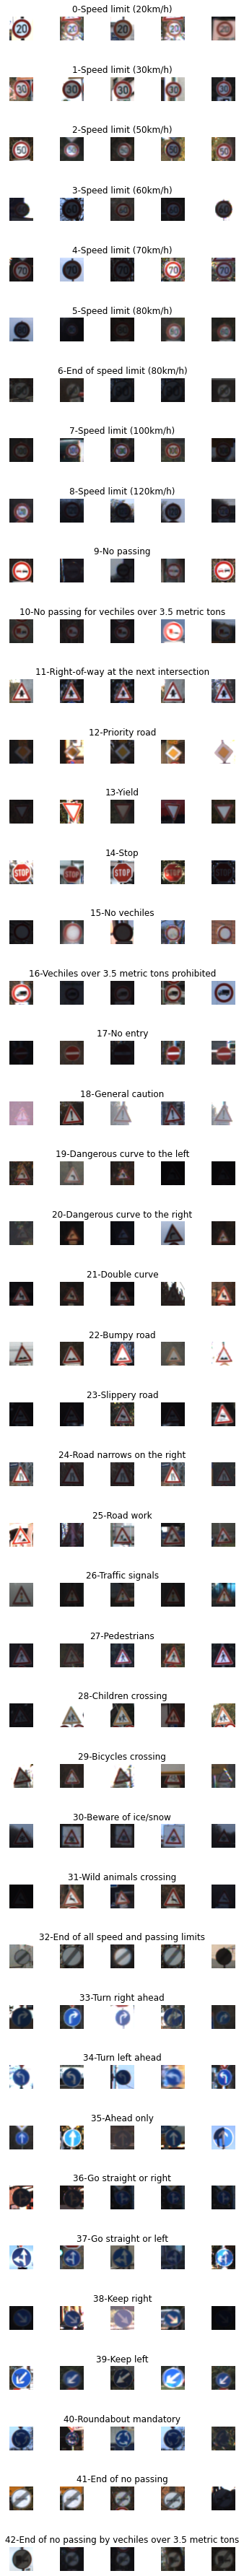

In [14]:
num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in sign_names.iterrows():
        x_selected = x_train[y_train == j]
        random_index = random.randint(0, (x_selected.shape[0]-1))
        axs[j][i].imshow(x_selected[random_index, :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row['SignName'])
            num_of_samples.append(len(x_selected))

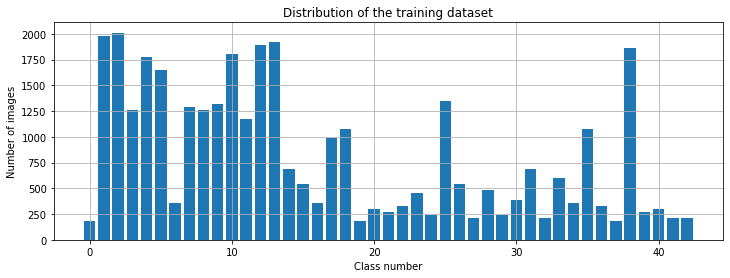

In [15]:
plt.figure(figsize=(12, 4))
plt.grid(axis='both')
plt.bar(range(0, num_classes), num_of_samples);
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images");

In [16]:
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np

In [17]:
def preprocesssing(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  eq = cv2.equalizeHist(gray)
  scaled_img = eq/255
  return scaled_img

In [18]:
x_train = np.array(list(map(preprocesssing, x_train)))

In [19]:
x_test = np.array(list(map(preprocesssing, x_test)))

In [20]:
x_val = np.array(list(map(preprocesssing, x_val)))

In [21]:
x_train.shape

(34799, 32, 32)

In [22]:
x_test.shape

(12630, 32, 32)

In [23]:
x_val.shape

(4410, 32, 32)

In [24]:

x_train = x_train.reshape(34799, 32, 32, 1)
x_test = x_test.reshape(12630, 32, 32, 1)
x_val = x_val.reshape(4410, 32, 32, 1)

In [25]:
y_train = to_categorical(y=y_train, num_classes=43)
y_test = to_categorical(y=y_test, num_classes=43)
y_val = to_categorical(y=y_val, num_classes=43)

In [33]:
def lenet():
  model = tf.keras.Sequential([tf.keras.layers.Conv2D(30, (5,5), input_shape=[32, 32, 1], activation='relu'),
                               tf.keras.layers.MaxPooling2D((2,2)),
                               tf.keras.layers.Conv2D(15, (3,3), activation='relu'),
                               tf.keras.layers.MaxPooling2D((2,2)),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(500, activation='relu'),
                               tf.keras.layers.Dropout(0.5),
                               tf.keras.layers.Dense(43, activation='softmax')])
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [34]:
lenet_model = lenet()
lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 30)        780       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 15)        4065      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 15)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 540)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               270500    
_________________________________________________________________
dropout (Dropout)            (None, 500)              

In [35]:
lenet_model.fit(x_train, y_train, epochs=10, batch_size=400, validation_data=(x_val, y_val), verbose=1, shuffle=1)

Epoch 1/10
87/87 [==============================] - 29s 336ms/step - loss: 2.2772 - accuracy: 0.3704 - val_loss: 1.1280 - val_accuracy: 0.6444
Epoch 2/10
87/87 [==============================] - 27s 315ms/step - loss: 0.8864 - accuracy: 0.7136 - val_loss: 0.7877 - val_accuracy: 0.7551
Epoch 3/10
87/87 [==============================] - 28s 316ms/step - loss: 0.6498 - accuracy: 0.7886 - val_loss: 0.6423 - val_accuracy: 0.8020
Epoch 4/10
87/87 [==============================] - 27s 316ms/step - loss: 0.5192 - accuracy: 0.8286 - val_loss: 0.5835 - val_accuracy: 0.8297
Epoch 5/10
87/87 [==============================] - 27s 316ms/step - loss: 0.4427 - accuracy: 0.8550 - val_loss: 0.5288 - val_accuracy: 0.8426
Epoch 6/10
87/87 [==============================] - 28s 316ms/step - loss: 0.3941 - accuracy: 0.8698 - val_loss: 0.5483 - val_accuracy: 0.8490
Epoch 7/10
87/87 [==============================] - 28s 317ms/step - loss: 0.3620 - accuracy: 0.8812 - val_loss: 0.4997 - val_accuracy: 0.8567

In [36]:
acc = lenet_model.history.history['accuracy']
val_acc = lenet_model.history.history['val_accuracy']
loss = lenet_model.history.history['loss']
val_loss = lenet_model.history.history['val_loss']

Text(0.5, 1.0, 'accuracy vs validation accuracy')

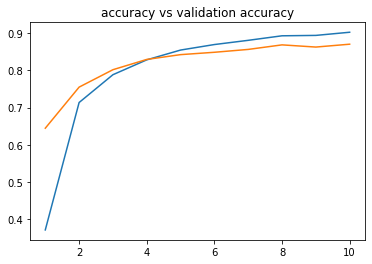

In [37]:
num_epochs = range(1, 11)
plt.plot(num_epochs, acc)
plt.plot(num_epochs, val_acc)
plt.title('accuracy vs validation accuracy')

Text(0.5, 1.0, 'loss vs validation loss')

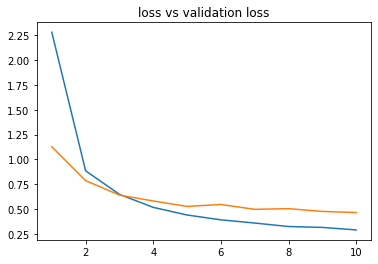

In [38]:
num_epochs = range(1, 11)
plt.plot(num_epochs, loss)
plt.plot(num_epochs, val_loss)
plt.title('loss vs validation loss')

In [39]:
score = lenet_model.evaluate(x_test, y_test, verbose=0)

In [40]:
print(f'Test loss: {score[0]}')
print(f'Test acc: {score[1]}')

Test loss: 0.6152156591415405
Test acc: 0.8520190119743347


# Fine Tuning Network for better performance

we currently have two main issues to fix:

1. Poor accuracy

2. Overfitting

In [41]:
def modified_lenet():
  model = tf.keras.Sequential([tf.keras.layers.Conv2D(30, (5,5), input_shape=[32, 32, 1], activation='relu'),
                               tf.keras.layers.MaxPooling2D((2,2)),
                               tf.keras.layers.Conv2D(15, (3,3), activation='relu'),
                               tf.keras.layers.MaxPooling2D((2,2)),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(500, activation='relu'),
                               tf.keras.layers.Dropout(0.5),
                               tf.keras.layers.Dense(43, activation='softmax')])
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [42]:
new_model = modified_lenet()

In [43]:
new_model.fit(x_train, y_train, epochs=10, batch_size=400, validation_data=(x_val, y_val), verbose=1, shuffle=1)

Epoch 1/10
87/87 [==============================] - 29s 335ms/step - loss: 2.5748 - accuracy: 0.3251 - val_loss: 1.2755 - val_accuracy: 0.6349
Epoch 2/10
87/87 [==============================] - 29s 334ms/step - loss: 0.8881 - accuracy: 0.7321 - val_loss: 0.6086 - val_accuracy: 0.8172
Epoch 3/10
87/87 [==============================] - 29s 331ms/step - loss: 0.4956 - accuracy: 0.8515 - val_loss: 0.4535 - val_accuracy: 0.8587
Epoch 4/10
87/87 [==============================] - 29s 336ms/step - loss: 0.3469 - accuracy: 0.8970 - val_loss: 0.3606 - val_accuracy: 0.8891
Epoch 5/10
87/87 [==============================] - 30s 340ms/step - loss: 0.2651 - accuracy: 0.9196 - val_loss: 0.3215 - val_accuracy: 0.8980
Epoch 6/10
87/87 [==============================] - 29s 333ms/step - loss: 0.2147 - accuracy: 0.9355 - val_loss: 0.3229 - val_accuracy: 0.9029
Epoch 7/10
87/87 [==============================] - 29s 336ms/step - loss: 0.1740 - accuracy: 0.9492 - val_loss: 0.2859 - val_accuracy: 0.9109

Text(0.5, 0, 'epochs')

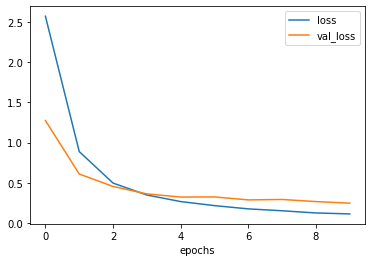

In [44]:
plt.plot(new_model.history.history['loss'])
plt.plot(new_model.history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('epochs')

In [45]:
score = new_model.evaluate(x_test, y_test, verbose=0)

In [46]:
print(f'Test loss: {score[0]}')
print(f'Test acc: {score[1]}')

Test loss: 0.35483503341674805
Test acc: 0.9125890731811523


In [47]:
def modified_lenet():
  model = tf.keras.Sequential([tf.keras.layers.Conv2D(60, (5,5), input_shape=[32, 32, 1], activation='relu'),
                               tf.keras.layers.MaxPooling2D((2,2)),
                               tf.keras.layers.Conv2D(30, (3,3), activation='relu'),
                               tf.keras.layers.MaxPooling2D((2,2)),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(500, activation='relu'),
                               tf.keras.layers.Dropout(0.5),
                               tf.keras.layers.Dense(43, activation='softmax')])
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [48]:
new_model = modified_lenet()

In [49]:
new_model.fit(x_train, y_train, epochs=10, batch_size=400, validation_data=(x_val, y_val), verbose=1, shuffle=1)

Epoch 1/10
87/87 [==============================] - 49s 565ms/step - loss: 2.4191 - accuracy: 0.3506 - val_loss: 1.0924 - val_accuracy: 0.6943
Epoch 2/10
87/87 [==============================] - 48s 555ms/step - loss: 0.7765 - accuracy: 0.7594 - val_loss: 0.5271 - val_accuracy: 0.8522
Epoch 3/10
87/87 [==============================] - 48s 551ms/step - loss: 0.4277 - accuracy: 0.8680 - val_loss: 0.3608 - val_accuracy: 0.8878
Epoch 4/10
87/87 [==============================] - 48s 552ms/step - loss: 0.2810 - accuracy: 0.9162 - val_loss: 0.3120 - val_accuracy: 0.9014
Epoch 5/10
87/87 [==============================] - 48s 550ms/step - loss: 0.2100 - accuracy: 0.9383 - val_loss: 0.2647 - val_accuracy: 0.9120
Epoch 6/10
87/87 [==============================] - 48s 549ms/step - loss: 0.1644 - accuracy: 0.9522 - val_loss: 0.2422 - val_accuracy: 0.9247
Epoch 7/10
87/87 [==============================] - 48s 557ms/step - loss: 0.1317 - accuracy: 0.9616 - val_loss: 0.2391 - val_accuracy: 0.9220

Text(0.5, 0, 'epochs')

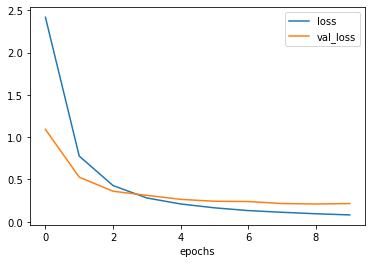

In [50]:
plt.plot(new_model.history.history['loss'])
plt.plot(new_model.history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('epochs')

In [51]:
score = new_model.evaluate(x_test, y_test, verbose=0)

In [52]:
print(f'Test loss: {score[0]}')
print(f'Test acc: {score[1]}')

Test loss: 0.31362640857696533
Test acc: 0.9212192893028259


In [27]:
def modified_model():
  model = tf.keras.Sequential([tf.keras.layers.Conv2D(60, (5,5), input_shape=[32, 32, 1], activation='relu'),
                               tf.keras.layers.Conv2D(60, (5,5), activation='relu'),
                               tf.keras.layers.MaxPooling2D((2,2)),
                               tf.keras.layers.Conv2D(30, (3,3), activation='relu'),
                               tf.keras.layers.Conv2D(30, (3,3), activation='relu'),
                               tf.keras.layers.MaxPooling2D((2,2)),
                               tf.keras.layers.Dropout(0.5),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(500, activation='relu'),
                               tf.keras.layers.Dropout(0.5),
                               tf.keras.layers.Dense(43, activation='softmax')])
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [28]:
new_model = modified_model()

In [29]:
new_model.fit(x_train, y_train, epochs=10, batch_size=400, validation_data=(x_val, y_val), verbose=1, shuffle=1)

Epoch 1/10
87/87 [==============================] - 3s 30ms/step - loss: 2.4634 - accuracy: 0.3346 - val_loss: 0.8019 - val_accuracy: 0.7769
Epoch 2/10
87/87 [==============================] - 2s 25ms/step - loss: 0.7567 - accuracy: 0.7681 - val_loss: 0.2977 - val_accuracy: 0.9109
Epoch 3/10
87/87 [==============================] - 2s 25ms/step - loss: 0.4233 - accuracy: 0.8680 - val_loss: 0.1876 - val_accuracy: 0.9456
Epoch 4/10
87/87 [==============================] - 2s 25ms/step - loss: 0.3037 - accuracy: 0.9032 - val_loss: 0.1424 - val_accuracy: 0.9549
Epoch 5/10
87/87 [==============================] - 2s 25ms/step - loss: 0.2387 - accuracy: 0.9253 - val_loss: 0.1198 - val_accuracy: 0.9644
Epoch 6/10
87/87 [==============================] - 2s 25ms/step - loss: 0.1936 - accuracy: 0.9390 - val_loss: 0.0972 - val_accuracy: 0.9735
Epoch 7/10
87/87 [==============================] - 2s 25ms/step - loss: 0.1764 - accuracy: 0.9447 - val_loss: 0.0919 - val_accuracy: 0.9732
Epoch 8/10
87

Text(0.5, 0, 'epochs')

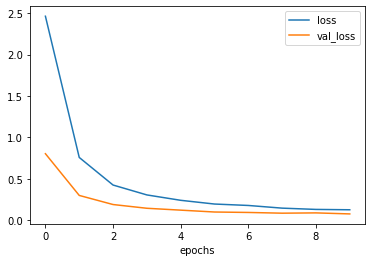

In [30]:
plt.plot(new_model.history.history['loss'])
plt.plot(new_model.history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

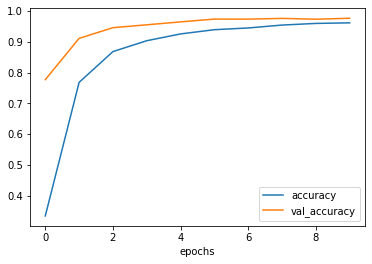

In [31]:
plt.plot(new_model.history.history['accuracy'])
plt.plot(new_model.history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('epochs')

In [32]:
score = new_model.evaluate(x_test, y_test, verbose=0)

In [33]:
print(f'Test loss: {score[0]}')
print(f'Test acc: {score[1]}')

Test loss: 0.1476505696773529
Test acc: 0.9586698412895203


it's absolutely a good thing for val_accuracy to be higher than train accuracy. as a matter of fact that's what we would want! when training accuracy is higher than validation accuracy there is a high chance we are overfitting or not optimal yet, at least.

# Testing our model performance!

In [40]:
urls = ['https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg',
        'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg',
        'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg',
        'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg',
        'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg']

In [42]:
import requests
from PIL import Image

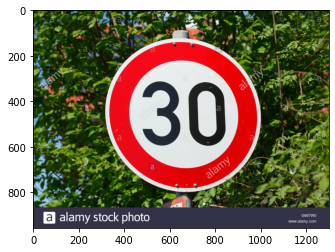

In [52]:
r = requests.get(urls[0], stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


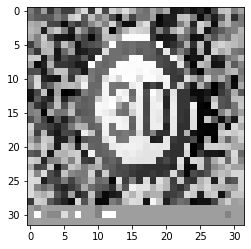

In [53]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocesssing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [54]:
img = img.reshape(1, 32, 32, 1) #take note of this reshaping for testing a single image!

In [55]:
#Test image
print("predicted sign: "+ str(np.argmax(new_model.predict(img))))

predicted sign: 0


In [56]:
sign_names.iloc[0, 1]

'Speed limit (20km/h)'

wrong prediction, should have been 30km/h

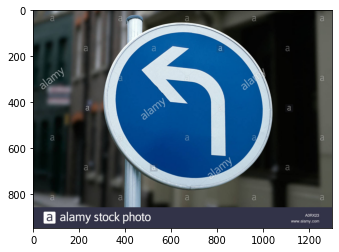

In [57]:
r = requests.get(urls[1], stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


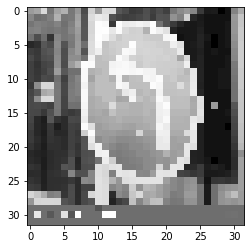

In [58]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocesssing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [59]:
img = img.reshape(1, 32, 32, 1)

In [60]:
#Test image
print("predicted sign: "+ sign_names.iloc[np.argmax(new_model.predict(img)), 1])

predicted sign: Priority road


Wrong prediction! should have been left turn!

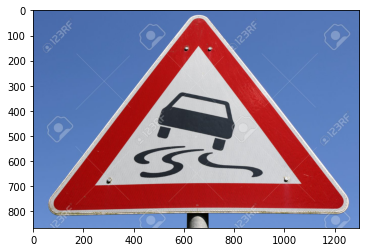

In [62]:
r = requests.get(urls[2], stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))


(32, 32)
predicted sign: Slippery road


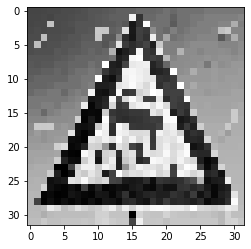

In [61]:

#Preprocess image
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocesssing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

img = img.reshape(1, 32, 32, 1)

#Test image
print("predicted sign: "+ sign_names.iloc[np.argmax(new_model.predict(img)), 1])

correct perdiction!

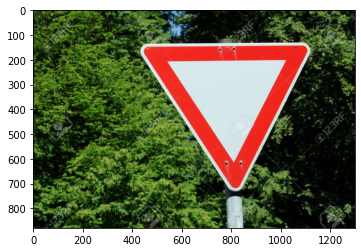

In [63]:
r = requests.get(urls[3], stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))


(32, 32)
predicted sign: Speed limit (50km/h)


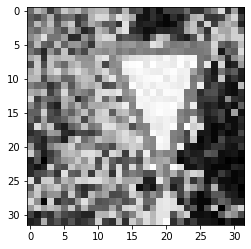

In [64]:

#Preprocess image
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocesssing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

img = img.reshape(1, 32, 32, 1)

#Test image
print("predicted sign: "+ sign_names.iloc[np.argmax(new_model.predict(img)), 1])

wrong prediction...lol

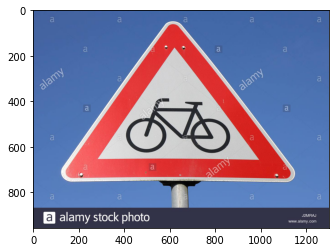

In [65]:
r = requests.get(urls[4], stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)
predicted sign: Wild animals crossing


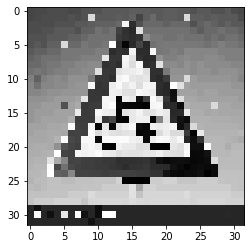

In [66]:

#Preprocess image
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocesssing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

img = img.reshape(1, 32, 32, 1)

#Test image
print("predicted sign: "+ sign_names.iloc[np.argmax(new_model.predict(img)), 1])

Wrong prediction!

# Augmentation!

alas, our fancy accuracy seems to be biased in some sort of way as our model failed to impress us on new data we collected from the internet...so let's try to increase our training data and see what happens

In [26]:
x_train, y_train = train_data['features'], train_data['labels']
x_test, y_test = test_data['features'], test_data['labels']
x_val, y_val = val_data['features'], val_data['labels']


x_train = np.array(list(map(preprocesssing, x_train)))
x_test = np.array(list(map(preprocesssing, x_test)))
x_val = np.array(list(map(preprocesssing, x_val)))

x_train = x_train.reshape(34799, 32, 32, 1)
x_test = x_test.reshape(12630, 32, 32, 1)
x_val = x_val.reshape(4410, 32, 32, 1)

y_train = to_categorical(y=y_train, num_classes=43)
y_test = to_categorical(y=y_test, num_classes=43)
y_val = to_categorical(y=y_val, num_classes=43)

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [28]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                   height_shift_range=0.1,
                   zoom_range=0.2,
                   shear_range=0.1,
                   rotation_range=10)

In [29]:
datagen.fit(x_train)

In [30]:
batches = datagen.flow(x_train, y_train, batch_size=20)

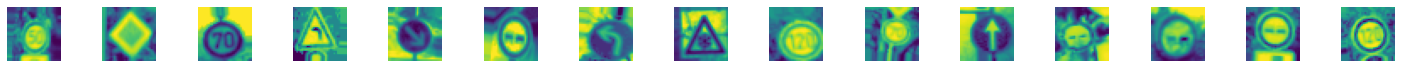

In [31]:
x_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(x_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [32]:
def modified_model():
  model = tf.keras.Sequential([tf.keras.layers.Conv2D(60, (5,5), input_shape=[32, 32, 1], activation='relu'),
                               tf.keras.layers.Conv2D(60, (5,5), activation='relu'),
                               tf.keras.layers.MaxPooling2D((2,2)),
                               tf.keras.layers.Conv2D(30, (3,3), activation='relu'),
                               tf.keras.layers.Conv2D(30, (3,3), activation='relu'),
                               tf.keras.layers.MaxPooling2D((2,2)),
                               #tf.keras.layers.Dropout(0.5),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(500, activation='relu'),
                               tf.keras.layers.Dropout(0.5),
                               tf.keras.layers.Dense(43, activation='softmax')])
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [33]:
new_model = modified_model()

In [34]:
new_model.fit(datagen.flow(x_train, y_train, batch_size=50), steps_per_epoch=680, epochs=10, validation_data=(x_val, y_val), shuffle=1)

Epoch 1/10
680/680 [==============================] - 10s 15ms/step - loss: 1.7186 - accuracy: 0.5114 - val_loss: 0.3763 - val_accuracy: 0.8751
Epoch 2/10
680/680 [==============================] - 10s 15ms/step - loss: 0.5846 - accuracy: 0.8205 - val_loss: 0.1603 - val_accuracy: 0.9510
Epoch 3/10
680/680 [==============================] - 11s 15ms/step - loss: 0.3631 - accuracy: 0.8863 - val_loss: 0.0988 - val_accuracy: 0.9732
Epoch 4/10
680/680 [==============================] - 10s 15ms/step - loss: 0.2721 - accuracy: 0.9147 - val_loss: 0.0794 - val_accuracy: 0.9751
Epoch 5/10
680/680 [==============================] - 10s 15ms/step - loss: 0.2301 - accuracy: 0.9282 - val_loss: 0.0666 - val_accuracy: 0.9814
Epoch 6/10
680/680 [==============================] - 10s 15ms/step - loss: 0.1938 - accuracy: 0.9390 - val_loss: 0.0798 - val_accuracy: 0.9760
Epoch 7/10
680/680 [==============================] - 10s 15ms/step - loss: 0.1714 - accuracy: 0.9470 - val_loss: 0.0502 - val_accuracy:

Text(0.5, 0, 'epochs')

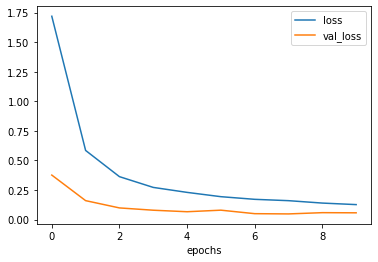

In [35]:
plt.plot(new_model.history.history['loss'])
plt.plot(new_model.history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

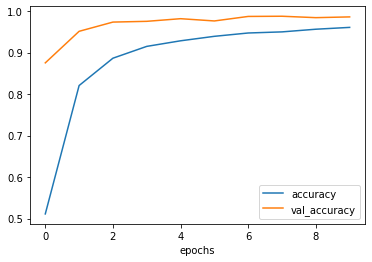

In [36]:
plt.plot(new_model.history.history['accuracy'])
plt.plot(new_model.history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('epochs')

In [38]:
import requests

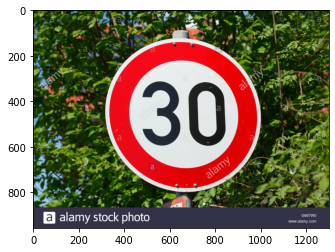

In [46]:
r = requests.get(urls[0], stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)
predicted sign: Speed limit (30km/h)


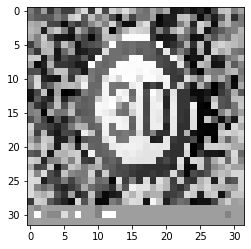

In [47]:
#Preprocess image
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocesssing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

img = img.reshape(1, 32, 32, 1)

#Test image
print("predicted sign: "+ sign_names.iloc[np.argmax(new_model.predict(img)), 1])

our model scores 4/5 unable to correctly predict bicycles crossing alone